# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [95]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [96]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.49.0', '2.3.0+cu121')

In [97]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading dataset

In [98]:
import datasets
from datasets import DatasetDict

###1. Load Dataset
task_name = "hate_speech18"
raw_datasets = datasets.load_dataset("hate_speech18")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})

In [99]:
train_val_split = raw_datasets['train'].train_test_split(test_size=0.1)
test_val_split = train_val_split['test'].train_test_split(test_size=0.5)

final_dataset  = DatasetDict({
    'train': train_val_split['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
})

In [100]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 9849
    })
    validation: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 547
    })
    test: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 548
    })
})

In [101]:
label_list = final_dataset['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'noHate': 0, 'hate': 1, 'idk/skip': 2, 'relation': 3}

In [102]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'noHate', 1: 'hate', 2: 'idk/skip', 3: 'relation'}

## 2. Model & Tokenization

In [103]:
import numpy as np 
num_labels = np.unique(final_dataset['train']['label']).size
num_labels

4

<img src = "figures/BERT_embed.png" width=500>

In [104]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing 

In [134]:
def tokenize_function(examples):
    sentence_key = 'text'
    result = tokenizer(examples[sentence_key], padding="max_length", truncation=True, max_length=128)
    return result

In [135]:
tokenized_datasets = final_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/9849 [00:00<?, ? examples/s]

Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/548 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9849
    })
    validation: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 547
    })
    test: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 548
    })
})

In [136]:
column_dataset = ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
column_dataset 

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

In [137]:
tokenized_datasets = tokenized_datasets.remove_columns([col for col in tokenized_datasets['train'].column_names if col not in column_dataset])

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format(type='torch', columns=['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [138]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 11721, 28878,  6380,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [139]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] gambit denied. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [140]:
tokenizer.save_pretrained("saved_tokenizer")

('saved_tokenizer/tokenizer_config.json',
 'saved_tokenizer/special_tokens_map.json',
 'saved_tokenizer/vocab.txt',
 'saved_tokenizer/added_tokens.json',
 'saved_tokenizer/tokenizer.json')

In [141]:
teacher_model.save_pretrained("exported_teacher_model")

## 4. Preparing the dataloader

In [142]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [143]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(9000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(500))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(500))

In [144]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [145]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [146]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "noHate",
    "1": "hate",
    "2": "idk/skip",
    "3": "relation"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "idk/skip": 2,
    "noHate": 0,
    "relation": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [147]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [148]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [149]:
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "noHate",
    "1": "hate",
    "2": "idk/skip",
    "3": "relation"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "idk/skip": 2,
    "noHate": 0,
    "relation": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [150]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [151]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights_odd(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_odd(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        
        odd_layer_indices = [0, 2, 4, 6, 8, 10]
        print("Using Odd Layers")

        for i, idx in enumerate(odd_layer_indices):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[idx].state_dict())
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [152]:
model = distill_bert_weights_odd(teacher=teacher_model, student=model)

Using Odd Layers


In [153]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model))

Teacher parameters : 109485316
Student parameters : 66958084


In [154]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.157136359728824

In [155]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [156]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [157]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [158]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [159]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [160]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [161]:
#!pip3 install evaluate

In [162]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    # metric = evaluate.load("glue", task_name)
    metric = evaluate.load("accuracy")
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [163]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
def Train(model, model_name):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0
    
    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)
    
            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))
    
        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)
    
            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)
    # Save the final model with a filename that depends on the model type.
    torch.save(model.state_dict(), f'{model_name}.pt')
    print(f'Model saved as {model_name}.pt')
    # Plotting
    epochs_list = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Train odd layer

  0%|          | 0/1410 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3600:
  - Loss_cls: 0.7547
  - Loss_div: 0.2092
  - Loss_cos: 0.1161
Epoch at 1: Test Acc 0.8960
Epoch at 2: Train loss 0.3319:
  - Loss_cls: 0.6527
  - Loss_div: 0.2474
  - Loss_cos: 0.0958
Epoch at 2: Test Acc 0.8920
Epoch at 3: Train loss 0.3164:
  - Loss_cls: 0.5910
  - Loss_div: 0.2656
  - Loss_cos: 0.0924
Epoch at 3: Test Acc 0.8800
Epoch at 4: Train loss 0.3075:
  - Loss_cls: 0.5567
  - Loss_div: 0.2749
  - Loss_cos: 0.0908
Epoch at 4: Test Acc 0.8860
Epoch at 5: Train loss 0.3038:
  - Loss_cls: 0.5404
  - Loss_div: 0.2805
  - Loss_cos: 0.0904
Epoch at 5: Test Acc 0.8860
Avg Metric 0.8880000000000001
Model saved as distil_odd_model.pt


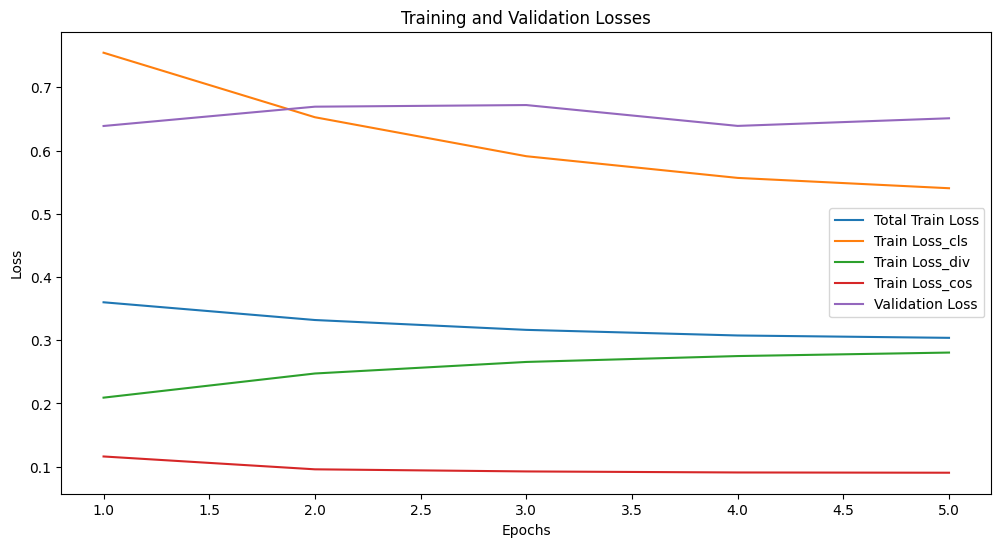

In [39]:
Train(model, 'distil_odd_model')

### Train even layer

In [40]:
def distill_bert_weights_even(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_even(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        
        even_layer_indices = [1, 3, 5, 7, 9, 11]
        print("Using Even Layers")

        for i, idx in enumerate(even_layer_indices):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[idx].state_dict())
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [41]:
model = distill_bert_weights_even(teacher=teacher_model, student=model)

Using Even Layers


In [42]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.157136359728824

  0%|          | 0/1410 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.8601:
  - Loss_cls: 1.6429
  - Loss_div: 0.0173
  - Loss_cos: 0.9201
Epoch at 1: Test Acc 0.0180
Epoch at 2: Train loss 0.8633:
  - Loss_cls: 1.6425
  - Loss_div: 0.0173
  - Loss_cos: 0.9299
Epoch at 2: Test Acc 0.0180
Epoch at 3: Train loss 0.8632:
  - Loss_cls: 1.6411
  - Loss_div: 0.0171
  - Loss_cos: 0.9314
Epoch at 3: Test Acc 0.0180
Epoch at 4: Train loss 0.8640:
  - Loss_cls: 1.6436
  - Loss_div: 0.0173
  - Loss_cos: 0.9310
Epoch at 4: Test Acc 0.0180
Epoch at 5: Train loss 0.8613:
  - Loss_cls: 1.6421
  - Loss_div: 0.0171
  - Loss_cos: 0.9247
Epoch at 5: Test Acc 0.0180
Avg Metric 0.018
Model saved as distil_even_model.pt


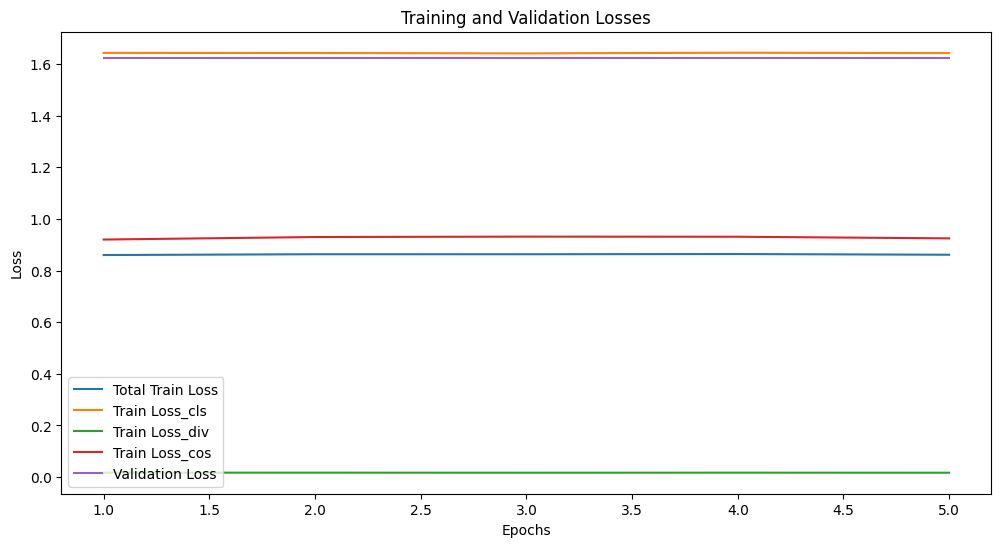

In [43]:
Train(model, 'distil_even_model')

### LoRA

In [181]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

configuration = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,           
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

model = get_peft_model(model, configuration)
model.print_trainable_parameters() 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 294,912 || all params: 109,780,228 || trainable%: 0.2686


In [182]:
from transformers import AdamW, get_scheduler

# Set up the optimizer for the LoRA model.
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate training steps.
steps_per_epoch = len(train_dataloader)
total_steps = 5 * steps_per_epoch
warmup_steps = int(0.1 * total_steps)

# Create a linear scheduler with warmup.
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [193]:
from tqdm.auto import tqdm
import evaluate

def train_step(model, teacher_model, batch, optimizer, scheduler, criterion_div, criterion_cos, device):
    model.train()
    teacher_model.eval()
    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(**batch)

    with torch.no_grad():
        output_teacher = teacher_model(**batch)

    assert outputs.logits.size() == output_teacher.logits.size(), "Logits size mismatch"

    # Compute losses
    loss_cls = outputs.loss
    temperature = 2.0
    loss_div = criterion_div(
        nn.functional.log_softmax(outputs.logits / temperature, dim=-1),
        nn.functional.softmax(output_teacher.logits / temperature, dim=-1)
    ) * (temperature ** 2)
    target = torch.ones(outputs.logits.size(0), device=device)
    loss_cos = criterion_cos(output_teacher.logits, outputs.logits, target)

    # Total loss (weighted average)
    loss = (loss_cls + loss_div + loss_cos) / 3

    # Backward and optimize
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item(), loss_cls.item(), loss_div.item(), loss_cos.item()

In [194]:
def eval_step(model, eval_dataloader, metric, device):
    model.eval()
    eval_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_cls = outputs.loss
            preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    eval_metric = metric.compute(predictions=all_preds, references=all_labels)
    return eval_loss / len(eval_dataloader), eval_metric

In [202]:
def train(model, teacher_model, optimizer, scheduler, train_dataloader, eval_dataloader,
          criterion_div, criterion_cos, num_epochs=5, device="cuda", output_file="lora_model.pt"):

    model.to(device)
    teacher_model.to(device)
    metric = evaluate.load("accuracy")

    # Track loss and metrics
    train_losses, train_cls_losses, train_div_losses, train_cos_losses = [], [], [], []
    eval_losses, eval_metrics_list = [], []
    accuracies_per_epoch = []

    progress_bar = tqdm(range(num_epochs * len(train_dataloader)), desc="Training")

    for epoch in range(num_epochs):
        total_loss, total_cls, total_div, total_cos = 0, 0, 0, 0

        for batch in train_dataloader:
            loss, loss_cls, loss_div, loss_cos = train_step(
                model, teacher_model, batch, optimizer, scheduler, criterion_div, criterion_cos, device
            )
            total_loss += loss
            total_cls += loss_cls
            total_div += loss_div
            total_cos += loss_cos
            progress_bar.update(1)

        # Store training loss per epoch
        train_losses.append(total_loss / len(train_dataloader))
        train_cls_losses.append(total_cls / len(train_dataloader))
        train_div_losses.append(total_div / len(train_dataloader))
        train_cos_losses.append(total_cos / len(train_dataloader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, cls={train_cls_losses[-1]:.4f}, div={train_div_losses[-1]:.4f}, cos={train_cos_losses[-1]:.4f}")

        # Evaluation
        eval_loss, eval_metric = eval_step(model, eval_dataloader, metric, device)
        eval_losses.append(eval_loss)
        eval_metrics_list.append(eval_metric)
        accuracies_per_epoch.append(eval_metric["accuracy"])

        print(f"Epoch {epoch+1}: Eval Loss={eval_loss:.4f}, Accuracy={eval_metric['accuracy']:.4f}")

    final_avg_accuracy = sum(accuracies_per_epoch) / num_epochs
    print(f"\nFinal Avg Accuracy: {final_avg_accuracy:.4f}")

    # Save results
    results = {
        "train_losses": train_losses,
        "train_cls": train_cls_losses,
        "train_div": train_div_losses,
        "train_cos": train_cos_losses,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "accuracies_per_epoch": accuracies_per_epoch,
        "final_avg_metrics": {"accuracy": final_avg_accuracy}
    }

    # Plotting losses
    epochs_list = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_cls_losses, label='Train Loss_cls')
    plt.plot(epochs_list, train_div_losses, label='Train Loss_div')
    plt.plot(epochs_list, train_cos_losses, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')

    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    torch.save(results, output_file)
    print(f"Training results saved to {output_file}")

    return results

Training:   0%|          | 0/1410 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.3964, cls=0.9020, div=0.0997, cos=0.1876
Epoch 1: Eval Loss=0.8724, Accuracy=0.8780
Epoch 2: Train Loss=0.3967, cls=0.9029, div=0.0995, cos=0.1878
Epoch 2: Eval Loss=0.8724, Accuracy=0.8780
Epoch 3: Train Loss=0.3965, cls=0.9013, div=0.1000, cos=0.1882
Epoch 3: Eval Loss=0.8724, Accuracy=0.8780
Epoch 4: Train Loss=0.3965, cls=0.9016, div=0.0998, cos=0.1882
Epoch 4: Eval Loss=0.8724, Accuracy=0.8780
Epoch 5: Train Loss=0.3965, cls=0.9025, div=0.0994, cos=0.1876
Epoch 5: Eval Loss=0.8724, Accuracy=0.8780

Final Avg Accuracy: 0.8780


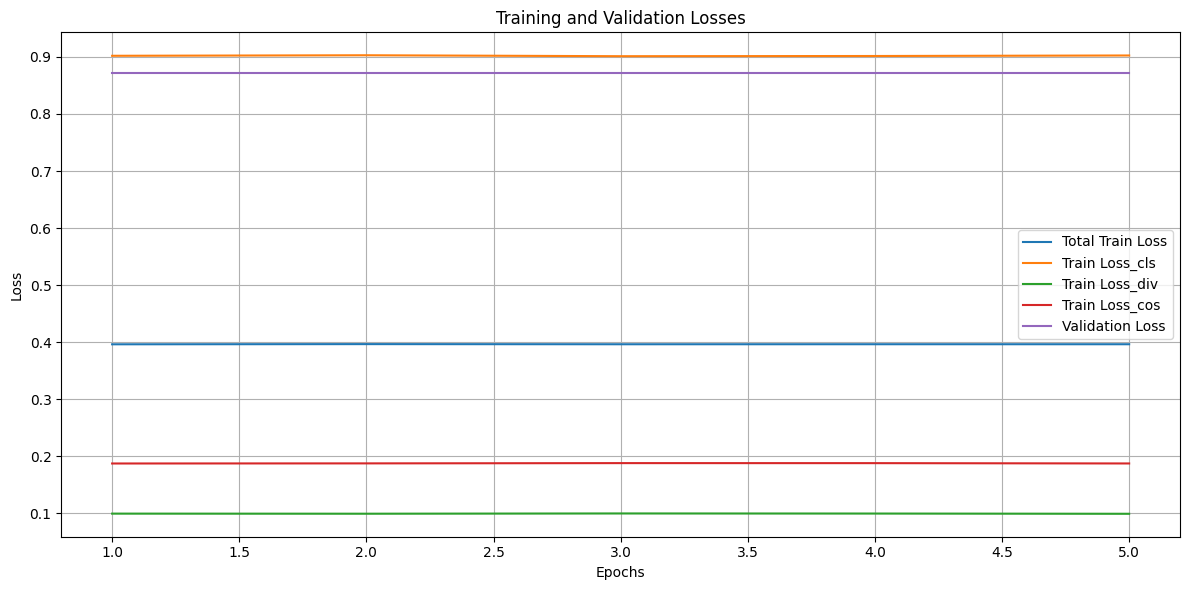

Training results saved to lora_model.pt


In [203]:
results = train(model, teacher_model, optimizer, scheduler, train_dataloader, eval_dataloader, criterion_div, criterion_cos, num_epochs=5, device="cuda")

### Inference

In [39]:
model = distill_bert_weights_odd(teacher=teacher_model, student=model)
model.load_state_dict(torch.load('distil_odd_model.pt', map_location=torch.device('cpu')))
model.eval()

Using Odd Layers


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [36]:
# Determine the device to use (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load your tokenizer (make sure it's the one used during training)
tokenizer = AutoTokenizer.from_pretrained("./saved_tokenizer")

# Sample text input.
text = "i hate you"
inputs = tokenizer(text, return_tensors="pt")

# Move the model and inputs to the same device
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference within a no_grad() context to disable gradient tracking.
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

# For classification, choose the class with the highest logit.
predicted_class_id = torch.argmax(logits, dim=-1).item()
label_mapping = {0: 'noHate', 1: 'hate', 2: 'idk/skip', 3: 'relation'}
predicted_label = label_mapping[predicted_class_id]
print("Predicted label:", predicted_label)

Predicted label: hate
